In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import pickle
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from training.networks import Generator  # ensure the new repo is part of your python path

# your trained network file 
path = "../data/raw/network-snapshot-002384.pkl"

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/workspace/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.10.1+cu102. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/workspace/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.10.1+cu102. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/workspace/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.10.1+cu102. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/workspace/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/workspace/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=[

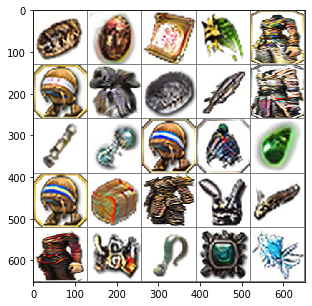

In [8]:
# generate some outputs from the network
# expect some warnings due to missing CUDA and C++ implementations
grid_dim = 5

with open(path, 'rb') as f:
    G = pickle.load(f)['G_ema'].cuda()  # torch.nn.Module
    z = torch.randn([grid_dim*grid_dim, G.z_dim]).cuda()    # latent codes
    c = None                                # class labels (not used in this example)
    out = G(z, c)                           # NCHW, float32, dynamic range [-1, +1]
grid = torchvision.utils.make_grid(out.cpu(), nrow=grid_dim)
grid = (grid * 127.5 + 128).clamp(0, 255).to(torch.uint8)

img = grid.detach().numpy()
img = np.transpose(img, (1, 2 ,0))
plt.figure(figsize = (grid_dim, grid_dim))
plt.imshow(img, interpolation='nearest')

In [9]:
# create a new network using the new defintion
G2 = Generator(
        G.z_dim,  # Input latent (Z) dimensionality.
        G.c_dim,  # Conditioning label (C) dimensionality.
        G.w_dim,  # Intermediate latent (W) dimensionality.
        G.img_resolution,  # Output resolution.
        G.img_channels,
).cpu()

# update the weights to match your trained model
g_sd = G.state_dict()
g2_sd = G2.state_dict()

for k, _ in g2_sd.items():
    g2_sd[k] = g_sd[k]
    
    
G2.load_state_dict(g2_sd)

import functools
G2.forward = functools.partial(G2.forward, c=None, force_fp32=True)

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/workspace/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.10.1+cu102. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/workspace/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.10.1+cu102. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/workspace/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.10.1+cu102. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/workspace/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/workspace/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=[

Failed!


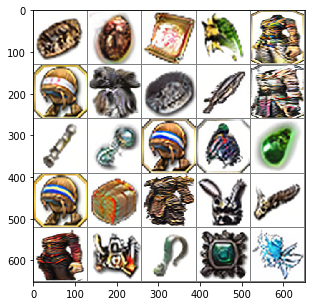

In [41]:
# verify visually that outputs are the same
out = G2(z)                           # NCHW, float32, dynamic range [-1, +1]
grid = torchvision.utils.make_grid(out.cpu(), nrow=grid_dim)
grid = (grid * 127.5 + 128).clamp(0, 255).to(torch.uint8)

img = grid.detach().numpy()
img = np.transpose(img, (1, 2 ,0))
plt.figure(figsize = (grid_dim, grid_dim))
plt.imshow(img, interpolation='nearest')

In [39]:
# export to TVM (via ONNX)
from tvm import relay
import onnx


def randn(inputs, input_types):
    return relay.expr.const(
        torch.randn(size=tuple(
            int(i.data.asnumpy()) if isinstance(i, relay.Constant) else int(i)
            for i in inputs[0])).numpy())


def square(inputs, input_types):
    data = inputs[0]
    dtype = input_types[0]
    print(type(inputs[0]))
    return relay.op.exp(inputs[0]**2)


def pytorch_exporter(model, use_onnx=False, batch_size=1, gpu=True):
    if gpu:
        model.cuda()
    else:
        model.cpu()
        test_input_datas = (torch.randn((batch_size, 512), dtype=torch.float32).cpu(), )
    # generate test outputs
    model.eval()
    outs = model(*test_input_datas)
    scripted_model = torch.jit.trace(model, test_input_datas).eval()
    shape_list = [("input0", [batch_size, 512])]

    if use_onnx:
        torch.onnx.export(
            scripted_model,
            *test_input_datas,
            "/tmp/model.onnx",
            export_params=True,
            verbose=False,
            input_names=['input0'],
            opset_version=10
        )
        return relay.frontend.from_onnx(onnx.load("/tmp/model.onnx"),
                                        freeze_params=True,
                                        shape={"input0": [batch_size, 512]})
    else:
        return relay.frontend.from_pytorch(
            scripted_model,
            shape_list,
            {
                "aten::randn": randn,
                "aten::square": square,
            },
        )

    print("Exported to TVM!")

        

In [40]:
mod, params = pytorch_exporter(G2, use_onnx=True, batch_size=1)
print("Exported to TVM!")


Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/workspace/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.10.1+cu102. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/workspace/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.10.1+cu102. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/workspace/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.10.1+cu102. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/workspace/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/workspace/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=[

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/workspace/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.10.1+cu102. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/workspace/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.10.1+cu102. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/workspace/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.10.1+cu102. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/workspace/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/workspace/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=[

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/workspace/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.10.1+cu102. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/workspace/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/workspace/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
  File "/workspace/stylegan2-ada-pytorch/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py", line 1124, in load
    return _jit_compile(
  File "/usr/local/lib/python3.8/dist-packages/torch/utils

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/workspace/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.10.1+cu102. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/workspace/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.10.1+cu102. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/workspace/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.10.1+cu102. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/workspace/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/workspace/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=[

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/workspace/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.10.1+cu102. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/workspace/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/workspace/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
  File "/workspace/stylegan2-ada-pytorch/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py", line 1124, in load
    return _jit_compile(
  File "/usr/local/lib/python3.8/dist-packages/torch/utils

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/workspace/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.10.1+cu102. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/workspace/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.10.1+cu102. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/workspace/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.10.1+cu102. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/workspace/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/workspace/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=[

Failed!


/usr/local/lib/python3.8/dist-packages/torch/onnx/utils.py:356: UserWarning: Model has no forward function
  warnings.warn("Model has no forward function")


hey there 3 3
Hey there indices_or_sections is [1] <class 'list'>
hey there 4 4
Hey there indices_or_sections is [1, 2] <class 'list'>
hey there 4 4
hey there 4 4
Hey there indices_or_sections is [1, 2] <class 'list'>
hey there 4 4
hey there 4 4
Hey there indices_or_sections is [1, 2] <class 'list'>
hey there 4 4
hey there 4 4
Hey there indices_or_sections is [1, 2] <class 'list'>
hey there 4 4
hey there 4 4
Hey there indices_or_sections is [1, 2] <class 'list'>
hey there 4 4
hey there 4 4
Exported to TVM!


In [48]:
import tvm

def run_gpu(mod, params, z_np):

    target = tvm.target.Target(
        "cuda",
        host="llvm -mtriple=x86_64-linux-gnu -mcpu=core-avx2")
    dev = tvm.gpu(0)
    with tvm.transform.PassContext(opt_level=3):
        lib = relay.build(mod, target=target, params=params)
    from tvm.contrib import graph_executor

    dtype = "float32"
    input_name = "input0"
    m = graph_executor.GraphModule(lib["default"](dev))
    # Set inputs
    m.set_input(input_name, tvm.nd.array(z_np.astype(dtype)))
    # Execute
    m.run()
    # Get outputs
    tvm_output = m.get_output(0)
    print(m.benchmark(dev, number=10, repeat=3))
    return tvm_output

# test with first item
#tvm_out = run_gpu(mod, params, z.cpu().numpy()[0, :])  

/tvm/python/tvm/runtime/ndarray.py:413: UserWarning: Please use tvm.cuda() instead of tvm.gpu(). tvm.gpu() is going to be deprecated in 0.9.0
  warnings.warn(


Execution time summary:
 mean (ms)   median (ms)    max (ms)     min (ms)     std (ms)  
  332.3751     332.5240     332.5646     332.0366      0.2399   
               
